<a href="https://colab.research.google.com/github/eunyounghi1001-bot/Vehicle-Damage-Detection/blob/main/2_result_251221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 셀 1: 환경 설정
!pip install -q ultralytics opencv-python-headless

import torch
print(f"✅ GPU 사용 가능: {torch.cuda.is_available()}")
print(f"   GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.9 MB/s eta 0:00:00
✅ GPU 사용 가능: True
   GPU: Tesla T4


In [3]:
"""
============================================================
차량 파손 검출 시스템 - 완전한 파이프라인
============================================================

순서:
0. 데이터 만들기 (파손 여부 라벨링)
1. 자동차 여부 탐지
2. 파손 부위 탐지
3. 모델 학습하기
4. 추론하기
5. Precision & Recall 평가

============================================================
"""

# ============================================
# 0️⃣  데이터 만들기 (파손 여부 라벨링)
# ============================================

print("="*60)
print("0️⃣  데이터 준비 및 라벨 변환")
print("="*60)

"""
필요한 패키지 설치 (Colab 첫 실행 시)
"""
# !pip install -q ultralytics opencv-python-headless

from google.colab import drive
import os
import json
import shutil
from pathlib import Path
import yaml
import random
from tqdm import tqdm
import cv2
import numpy as np

# Google Drive 마운트
drive.mount('/content/drive')

# 데이터 경로 설정
base_path = '/content/drive/MyDrive/(share)2026_ImageDetectionStudy_No_resizing'
damaged_images = f'{base_path}/damaged/images'
damaged_labels = f'{base_path}/damaged/labels'  # JSON 파일
background_images = f'{base_path}/background/images'
normal_images = f'{base_path}/normal/images'

print(f"\n✅ 데이터 경로 설정 완료")
print(f"   damaged: {damaged_images}")
print(f"   normal: {normal_images}")
print(f"   background: {background_images}")


def convert_json_to_yolo(json_path, output_txt_path, img_width, img_height):
    """
    JSON 라벨을 YOLO TXT 형식으로 변환

    YOLO 형식: <class_id> <x_center> <y_center> <width> <height>
    (모든 값은 0~1로 정규화)
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        # 이미지 크기
        if 'images' in data:
            img_width = data['images'].get('width', img_width)
            img_height = data['images'].get('height', img_height)

        yolo_lines = []

        # annotations 처리
        if 'annotations' in data:
            annotations = data['annotations']
            if not isinstance(annotations, list):
                annotations = [annotations]

            for ann in annotations:
                if 'bbox' in ann:
                    bbox = ann['bbox']
                    x, y, w, h = bbox

                    # YOLO 형식으로 변환
                    x_center = (x + w / 2) / img_width
                    y_center = (y + h / 2) / img_height
                    width_norm = w / img_width
                    height_norm = h / img_height

                    class_id = 0  # damaged

                    yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}"
                    yolo_lines.append(yolo_line)

        # TXT 파일로 저장
        if yolo_lines:
            with open(output_txt_path, 'w') as f:
                f.write('\n'.join(yolo_lines))
            return True
        else:
            open(output_txt_path, 'w').close()
            return False

    except Exception as e:
        print(f"❌ 변환 오류: {e}")
        return False


# YOLO 데이터셋 구조 생성
output_root = 'yolo_dataset'
folders = [
    f'{output_root}/images/train',
    f'{output_root}/images/val',
    f'{output_root}/labels/train',
    f'{output_root}/labels/val',
]

for folder in folders:
    Path(folder).mkdir(parents=True, exist_ok=True)

print(f"\n✅ YOLO 데이터셋 폴더 생성 완료")


def process_dataset(img_folder, label_folder, split_ratio=0.8):
    """데이터 처리 및 train/val 분할"""

    if not os.path.exists(img_folder):
        return 0, 0

    image_files = [f for f in os.listdir(img_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    if len(image_files) == 0:
        return 0, 0

    random.shuffle(image_files)
    split_idx = int(len(image_files) * split_ratio)
    train_files = image_files[:split_idx]
    val_files = image_files[split_idx:]

    def copy_split(files, split_name):
        count = 0
        for img_file in tqdm(files, desc=f"{split_name}"):
            src_img = os.path.join(img_folder, img_file)
            dst_img = os.path.join(output_root, 'images', split_name, img_file)
            shutil.copy2(src_img, dst_img)

            # 이미지 크기
            img = cv2.imread(src_img)
            if img is None:
                continue
            img_height, img_width = img.shape[:2]

            # 라벨 처리
            base_name = os.path.splitext(img_file)[0]
            txt_file = base_name + '.txt'
            dst_txt = os.path.join(output_root, 'labels', split_name, txt_file)

            if label_folder and os.path.exists(label_folder):
                json_file = base_name + '.json'
                src_json = os.path.join(label_folder, json_file)

                if os.path.exists(src_json):
                    convert_json_to_yolo(src_json, dst_txt, img_width, img_height)
                else:
                    open(dst_txt, 'w').close()
            else:
                # 정상/배경 이미지 - 빈 라벨
                open(dst_txt, 'w').close()

            count += 1
        return count

    train_count = copy_split(train_files, 'train')
    val_count = copy_split(val_files, 'val')

    return train_count, val_count


print(f"\n📦 데이터 처리 중...\n")

# 파손 차량
print("1. 파손 차량 (damaged)")
damaged_train, damaged_val = process_dataset(damaged_images, damaged_labels)
print(f"   ✓ Train: {damaged_train}, Val: {damaged_val}")

# 정상 차량
print("\n2. 정상 차량 (normal)")
normal_train, normal_val = process_dataset(normal_images, None)
print(f"   ✓ Train: {normal_train}, Val: {normal_val}")

# 배경
print("\n3. 배경 (background)")
bg_train, bg_val = process_dataset(background_images, None)
print(f"   ✓ Train: {bg_train}, Val: {bg_val}")

total_train = damaged_train + normal_train + bg_train
total_val = damaged_val + normal_val + bg_val

print(f"\n✅ 데이터 준비 완료!")
print(f"   Train: {total_train}장")
print(f"   Val: {total_val}장")


# YAML 설정 파일 생성
config = {
    'path': os.path.abspath(output_root),
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,
    'names': ['damaged']
}

yaml_path = 'damage_detection.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f"\n✅ 설정 파일 생성: {yaml_path}")


# ============================================
# 1️⃣  자동차 여부 탐지 (YOLO 기본 모델)
# ============================================

print("\n\n" + "="*60)
print("1️⃣  자동차 인식 시스템")
print("="*60)

from ultralytics import YOLO

# 자동차 감지용 모델 (COCO 데이터셋)
vehicle_detector = YOLO('yolov8n.pt')

# 차량 클래스 ID (COCO)
vehicle_classes = {
    2: 'car',
    3: 'motorcycle',
    5: 'bus',
    7: 'truck'
}

def detect_vehicles(image_path, conf_threshold=0.5):
    """이미지에서 자동차 감지"""

    img = cv2.imread(image_path)
    results = vehicle_detector(img, conf=conf_threshold, verbose=False)

    vehicles = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls_id = int(box.cls[0])

            if cls_id in vehicle_classes:
                coords = box.xyxy[0].cpu().numpy().astype(int)
                conf = float(box.conf[0])

                vehicles.append({
                    'bbox': coords,
                    'confidence': conf,
                    'class': vehicle_classes[cls_id]
                })

    return vehicles, img

print("\n✅ 자동차 인식 모델 준비 완료")
print(f"   감지 가능: {list(vehicle_classes.values())}")


# ============================================
# 2️⃣  파손 부위 탐지 모델 (학습 필요)
# ============================================

print("\n\n" + "="*60)
print("2️⃣  파손 부위 탐지 모델 (학습 후 사용)")
print("="*60)

print("""
이 단계는 3️⃣ 학습 완료 후 사용 가능합니다.
학습된 모델로 차량 영역에서 파손 부위를 검출합니다.
""")


# ============================================
# 3️⃣  모델 학습하기
# ============================================

print("\n\n" + "="*60)
print("3️⃣  모델 학습")
print("="*60)

def train_damage_detection_model(
    data_yaml='damage_detection.yaml',
    model_size='n',  # n, s, m, l, x
    epochs=100,
    imgsz=640,
    batch=16
):
    """
    파손 검출 모델 학습

    Args:
        data_yaml: 데이터셋 설정 파일
        model_size: 모델 크기 (n=빠름, s=보통, m=정확)
        epochs: 학습 반복 횟수
        imgsz: 이미지 크기
        batch: 배치 크기
    """

    print(f"\n🚀 학습 시작...")
    print(f"   모델: yolov8{model_size}.pt")
    print(f"   Epochs: {epochs}")
    print(f"   이미지 크기: {imgsz}")
    print(f"   배치: {batch}")

    # 모델 초기화
    model = YOLO(f'yolov8{model_size}.pt')

    # 학습
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=50,
        save=True,
        device=0,  # GPU
        project='car_damage_model',
        name='train',
        exist_ok=True,

        # 최적화 설정
        lr0=0.01,
        lrf=0.01,
        momentum=0.937,
        weight_decay=0.0005,

        # 데이터 증강
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        degrees=10,
        translate=0.1,
        scale=0.5,
        fliplr=0.5,
        mosaic=1.0,
    )

    print(f"\n✅ 학습 완료!")
    print(f"   모델 저장: car_damage_model/train/weights/best.pt")

    return results

# 학습 실행 (주석 해제하여 사용)
print("\n학습을 시작하려면 아래 코드 실행:")
print("results = train_damage_detection_model(epochs=100)")
print("\n⏰ 예상 소요 시간: 1~2시간 (GPU 기준)")


# ============================================
# 4️⃣  추론하기 (학습된 모델로 검사)
# ============================================

print("\n\n" + "="*60)
print("4️⃣  추론 시스템 (2단계 검사)")
print("="*60)

class CarDamageInspector:
    """완전한 차량 파손 검사 시스템"""

    def __init__(self, damage_model_path='car_damage_model/train/weights/best.pt'):
        """
        초기화

        Args:
            damage_model_path: 학습된 파손 검출 모델 경로
        """
        print("\n🔧 검사 시스템 초기화...")

        # 1단계: 자동차 인식
        self.vehicle_detector = YOLO('yolov8n.pt')
        self.vehicle_classes = {2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}

        # 2단계: 파손 검출
        if os.path.exists(damage_model_path):
            self.damage_detector = YOLO(damage_model_path)
            print(f"   ✓ 파손 검출 모델 로드: {damage_model_path}")
        else:
            print(f"   ⚠️  모델 파일 없음: {damage_model_path}")
            print(f"   → 먼저 3️⃣ 학습을 완료하세요!")
            self.damage_detector = None

        print("✅ 초기화 완료!\n")

    def inspect(self, image_path, vehicle_conf=0.5, damage_conf=0.5):
        """
        완전한 검사 수행

        Returns:
            result: {
                'status': 'success' | 'no_vehicle' | 'error',
                'vehicles_found': int,
                'damaged_vehicles': int,
                'normal_vehicles': int,
                'overall_status': 'damaged' | 'normal' | 'no_vehicle'
            }
        """

        # 이미지 로드
        img = cv2.imread(image_path)
        if img is None:
            return {'status': 'error', 'message': '이미지 로드 실패'}

        print(f"\n{'='*60}")
        print(f"🔍 검사: {os.path.basename(image_path)}")
        print(f"{'='*60}")

        # 1단계: 자동차 감지
        print("\n1️⃣  자동차 인식 중...")
        results = self.vehicle_detector(img, conf=vehicle_conf, verbose=False)

        vehicles = []
        for result in results:
            for box in result.boxes:
                cls_id = int(box.cls[0])
                if cls_id in self.vehicle_classes:
                    vehicles.append({
                        'bbox': box.xyxy[0].cpu().numpy().astype(int),
                        'conf': float(box.conf[0]),
                        'class': self.vehicle_classes[cls_id]
                    })

        if len(vehicles) == 0:
            print("   ❌ 자동차 없음")
            return {
                'status': 'no_vehicle',
                'vehicles_found': 0,
                'damaged_vehicles': 0,
                'normal_vehicles': 0,
                'overall_status': 'no_vehicle'
            }

        print(f"   ✅ {len(vehicles)}대 감지")

        # 2단계: 파손 검사
        if self.damage_detector is None:
            print("\n⚠️  파손 검출 모델이 없습니다. 먼저 학습하세요!")
            return {'status': 'error', 'message': '모델 없음'}

        print("\n2️⃣  파손 검사 중...")

        damaged_count = 0
        for i, vehicle in enumerate(vehicles, 1):
            x1, y1, x2, y2 = vehicle['bbox']
            vehicle_crop = img[y1:y2, x1:x2]

            # 파손 검출
            damage_results = self.damage_detector(vehicle_crop, conf=damage_conf, verbose=False)
            damage_count = len(damage_results[0].boxes)

            if damage_count > 0:
                damaged_count += 1
                print(f"   ⚠️  차량 #{i}: 파손 ({damage_count}개)")
            else:
                print(f"   ✅ 차량 #{i}: 정상")

        # 최종 결과
        print(f"\n{'='*60}")
        print(f"📊 최종 결과")
        print(f"{'='*60}")
        print(f"차량: {len(vehicles)}대")
        print(f"파손: {damaged_count}대")
        print(f"정상: {len(vehicles) - damaged_count}대")

        if damaged_count > 0:
            print(f"\n⚠️  종합: 파손 차량 존재")
        else:
            print(f"\n✅ 종합: 모든 차량 정상")

        return {
            'status': 'success',
            'vehicles_found': len(vehicles),
            'damaged_vehicles': damaged_count,
            'normal_vehicles': len(vehicles) - damaged_count,
            'overall_status': 'damaged' if damaged_count > 0 else 'normal'
        }

print("\n추론 시스템 준비 완료")
print("\n사용 예제:")
print("inspector = CarDamageInspector()")
print("result = inspector.inspect('test_car.jpg')")


# ============================================
# 5️⃣  Precision & Recall 평가
# ============================================

print("\n\n" + "="*60)
print("5️⃣  성능 평가 (Precision & Recall)")
print("="*60)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class PerformanceEvaluator:
    """성능 평가 시스템"""

    def __init__(self):
        self.y_true = []  # 실제 라벨
        self.y_pred = []  # 예측 결과
        self.details = []

    def add_result(self, filename, ground_truth, prediction):
        """
        결과 추가

        Args:
            filename: 파일명
            ground_truth: 'damaged' | 'normal' | 'no_vehicle'
            prediction: 'damaged' | 'normal' | 'no_vehicle'
        """
        self.details.append({
            'file': filename,
            'true': ground_truth,
            'pred': prediction
        })

    def calculate_metrics(self, exclude_no_vehicle=True):
        """성능 지표 계산"""

        if len(self.details) == 0:
            print("❌ 평가할 데이터가 없습니다.")
            return

        # 데이터 필터링
        if exclude_no_vehicle:
            filtered = [d for d in self.details
                       if d['true'] != 'no_vehicle' and d['pred'] != 'no_vehicle']
        else:
            filtered = self.details

        if len(filtered) == 0:
            print("❌ 차량 데이터가 없습니다.")
            return

        # 이진 분류 변환
        y_true = [1 if d['true'] == 'damaged' else 0 for d in filtered]
        y_pred = [1 if d['pred'] == 'damaged' else 0 for d in filtered]

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # 메트릭 계산
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # 결과 출력
        print(f"\n{'='*60}")
        print(f"📊 성능 평가 결과")
        print(f"{'='*60}")

        print(f"\n📋 Confusion Matrix:")
        print(f"┌─────────────┬──────────┬──────────┐")
        print(f"│             │ 예측:정상 │ 예측:파손 │")
        print(f"├─────────────┼──────────┼──────────┤")
        print(f"│ 실제:정상    │   {tn:4d}   │   {fp:4d}   │")
        print(f"│ 실제:파손    │   {fn:4d}   │   {tp:4d}   │")
        print(f"└─────────────┴──────────┴──────────┘")

        print(f"\n📈 성능 지표:")
        print(f"┌─────────────────────┬──────────┐")
        print(f"│ Accuracy (정확도)    │ {accuracy:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Precision (정밀도)   │ {precision:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Recall (재현율)      │ {recall:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ F1-Score            │ {f1:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Specificity (특이도) │ {specificity:7.2%} │")
        print(f"└─────────────────────┴──────────┘")

        print(f"\n💡 지표 설명:")
        print(f"• Precision: 파손이라고 예측한 것 중 실제 파손 = {precision:.2%}")
        print(f"  → 높을수록 오탐(FP) 적음. 현재 오탐: {fp}건")
        print(f"\n• Recall: 실제 파손 중 찾아낸 비율 = {recall:.2%}")
        print(f"  → 높을수록 미탐(FN) 적음. 현재 미탐: {fn}건")
        print(f"\n• F1-Score: Precision과 Recall의 조화평균 = {f1:.2%}")

        # 시각화
        self._plot_results(cm, accuracy, precision, recall, f1)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        }

    def _plot_results(self, cm, accuracy, precision, recall, f1):
        """결과 시각화"""

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Damaged'],
                   yticklabels=['Normal', 'Damaged'],
                   ax=axes[0])
        axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Actual')
        axes[0].set_xlabel('Predicted')

        # 메트릭 바 차트
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [accuracy, precision, recall, f1]
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

        bars = axes[1].barh(metrics, values, color=colors, alpha=0.8)
        axes[1].set_xlabel('Score')
        axes[1].set_title('Performance Metrics', fontsize=14, fontweight='bold')
        axes[1].set_xlim(0, 1)
        axes[1].grid(axis='x', alpha=0.3)

        for bar, value in zip(bars, values):
            axes[1].text(value + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{value:.2%}', va='center', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.savefig('performance_metrics.png', dpi=150, bbox_inches='tight')
        plt.show()

        print(f"\n💾 그래프 저장: performance_metrics.png")

print("\n평가 시스템 준비 완료")


# ============================================
# 📚 완전한 사용 예제
# ============================================

print("\n\n" + "="*60)
print("📚 전체 프로세스 실행 예제")
print("="*60)

print("""
# ============================================
# 단계별 실행 가이드
# ============================================

# 0️⃣  데이터 준비 (위에서 이미 완료)
✅ JSON → YOLO 변환 완료
✅ Train/Val 분할 완료

# 3️⃣  모델 학습
results = train_damage_detection_model(epochs=100)
# ⏰ 약 1~2시간 소요

# 4️⃣  추론 테스트
inspector = CarDamageInspector()

# 단일 이미지 검사
result = inspector.inspect('test_car.jpg')

# 여러 이미지 검사
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    result = inspector.inspect(filename)

# 5️⃣  성능 평가
evaluator = PerformanceEvaluator()

# Validation 데이터로 평가
val_image_folder = 'yolo_dataset/images/val'
val_label_folder = 'yolo_dataset/labels/val'

for img_file in os.listdir(val_image_folder):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(val_image_folder, img_file)
    label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(val_label_folder, label_file)

    # Ground Truth
    has_damage_gt = False
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            has_damage_gt = len(f.read().strip()) > 0

    gt = 'damaged' if has_damage_gt else 'normal'

    # 예측
    result = inspector.inspect(img_path)
    pred = result['overall_status']

    evaluator.add_result(img_file, gt, pred)

# 메트릭 계산
metrics = evaluator.calculate_metrics()

print(f"\\n최종 성능:")
print(f"  Accuracy: {metrics['accuracy']:.2%}")
print(f"  Precision: {metrics['precision']:.2%}")
print(f"  Recall: {metrics['recall']:.2%}")
print(f"  F1-Score: {metrics['f1_score']:.2%}")
""")

print("\n" + "="*60)
print("✅ 전체 파이프라인 준비 완료!")
print("="*60)
print("\n위의 단계를 순서대로 실행하세요! 🚀")

0️⃣  데이터 준비 및 라벨 변환
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ 데이터 경로 설정 완료
   damaged: /content/drive/MyDrive/(share)2026_ImageDetectionStudy_No_resizing/damaged/images
   normal: /content/drive/MyDrive/(share)2026_ImageDetectionStudy_No_resizing/normal/images
   background: /content/drive/MyDrive/(share)2026_ImageDetectionStudy_No_resizing/background/images

✅ YOLO 데이터셋 폴더 생성 완료

📦 데이터 처리 중...

1. 파손 차량 (damaged)


val: 100%|██████████| 240/240 [05:19<00:00,  1.33s/it]


   ✓ Train: 960, Val: 240

2. 정상 차량 (normal)


val: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


   ✓ Train: 125, Val: 32

3. 배경 (background)


val: 100%|██████████| 120/120 [01:23<00:00,  1.44it/s]

   ✓ Train: 480, Val: 120

✅ 데이터 준비 완료!
   Train: 1565장
   Val: 392장

✅ 설정 파일 생성: damage_detection.yaml


1️⃣  자동차 인식 시스템
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



✅ 자동차 인식 모델 준비 완료
   감지 가능: ['car', 'motorcycle', 'bus', 'truck']


2️⃣  파손 부위 탐지 모델 (학습 후 사용)

이 단계는 3️⃣ 학습 완료 후 사용 가능합니다.
학습된 모델로 차량 영역에서 파손 부위를 검출합니다.



3️⃣  모델 학습

학습을 시작하려면 아래 코드 실행:
results = train_damage_detection_model(epochs=100)

⏰ 예상 소요 시간: 1~2시간 (GPU 기준)


4️⃣  추론 시스템 (2단계 검사)

추론 시스템 준비 완료

사용 예제:
inspector = CarDamageInspector()
result = inspector.inspect('test_car.jpg')


5️⃣  성능 평가 (Precision & Recall)

평가 시스템 준비 완료


📚 전체 프로세스 실행 예제

# ============================================
# 단계별 실행 가이드
# ============================================

# 0️⃣  데이터 준비 (위에서 이미 완료)
✅ JSON → YOLO 변환 완료
✅ Train/Val 분할 완료

# 3️⃣  모델 학습
results = train_damage_detection_model(epochs=100)
# ⏰ 약 1~2시간 소요

# 4️⃣  추론 테스트
inspector = CarDamageInspector()

# 단일 이미지 검사
result = inspector.inspect('test_car.jpg')

# 여러 이미지 검사
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    result = inspector.inspect(filename)

# 5️⃣  성능 평가
evaluator = PerformanceEvalua


🚀 학습 시작...
   모델: yolov8n.pt
   Epochs: 100
   이미지 크기: 640
   배치: 16
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=damage_detection.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m


🔍 검사: 0376413_sc-152469.jpg

1️⃣  자동차 인식 중...
   ✅ 1대 감지

2️⃣  파손 검사 중...
   ✅ 차량 #1: 정상

📊 최종 결과
차량: 1대
파손: 0대
정상: 1대

✅ 종합: 모든 차량 정상

🔍 검사: 0316349_sc-128467.jpg

1️⃣  자동차 인식 중...
   ❌ 자동차 없음

🔍 검사: 0136184_sc-138052.jpg

1️⃣  자동차 인식 중...
   ❌ 자동차 없음

🔍 검사: bg_0044.jpg

1️⃣  자동차 인식 중...
   ❌ 자동차 없음

🔍 검사: 0485896_sc-113408.jpg

1️⃣  자동차 인식 중...
   ✅ 1대 감지

2️⃣  파손 검사 중...
   ⚠️  차량 #1: 파손 (1개)

📊 최종 결과
차량: 1대
파손: 1대
정상: 0대

⚠️  종합: 파손 차량 존재

🔍 검사: 0057279_sc-199603.jpg

1️⃣  자동차 인식 중...
   ✅ 1대 감지

2️⃣  파손 검사 중...
   ✅ 차량 #1: 정상

📊 최종 결과
차량: 1대
파손: 0대
정상: 1대

✅ 종합: 모든 차량 정상

🔍 검사: 0350658_sc-221485.jpg

1️⃣  자동차 인식 중...
   ❌ 자동차 없음

🔍 검사: 0267781_sc-162261.jpg

1️⃣  자동차 인식 중...
   ❌ 자동차 없음

🔍 검사: bg_0103.jpg

1️⃣  자동차 인식 중...
   ❌ 자동차 없음

🔍 검사: 0125824_sc-136764.jpg

1️⃣  자동차 인식 중...
   ✅ 1대 감지

2️⃣  파손 검사 중...
   ✅ 차량 #1: 정상

📊 최종 결과
차량: 1대
파손: 0대
정상: 1대

✅ 종합: 모든 차량 정상

🔍 검사: 0050009_sc-226443.jpg

1️⃣  자동차 인식 중...
   ✅ 2대 감지

2️⃣  파손 검사 중...
   ✅ 차량 #1: 정상
   ✅ 차량 #2: 정상

📊 최종 결과

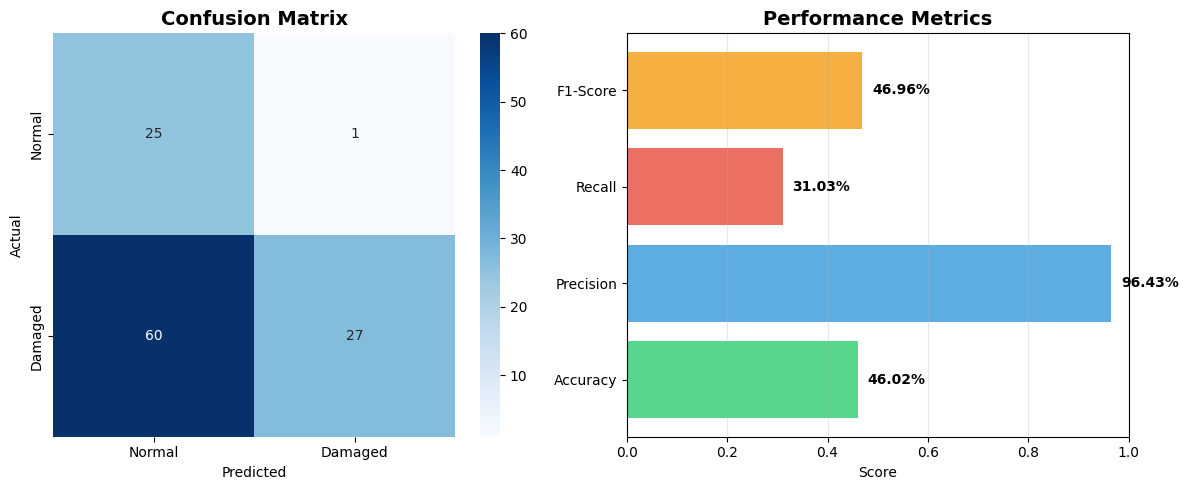


💾 그래프 저장: performance_metrics.png
\n최종 성능:
  Accuracy: 46.02%
  Precision: 96.43%
  Recall: 31.03%
  F1-Score: 46.96%


In [4]:
# 0️⃣  데이터 준비 (위에서 이미 완료)
# ✅ JSON → YOLO 변환 완료
# ✅ Train/Val 분할 완료

# 3️⃣  모델 학습
results = train_damage_detection_model(epochs=100)
# ⏰ 약 1~2시간 소요

# 4️⃣  추론 테스트
inspector = CarDamageInspector()

# 단일 이미지 검사
result = inspector.inspect('test_car.jpg')

# 여러 이미지 검사
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    result = inspector.inspect(filename)

# 5️⃣  성능 평가
evaluator = PerformanceEvaluator()

# Validation 데이터로 평가
val_image_folder = 'yolo_dataset/images/val'
val_label_folder = 'yolo_dataset/labels/val'

for img_file in os.listdir(val_image_folder):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(val_image_folder, img_file)
    label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(val_label_folder, label_file)

    # Ground Truth
    has_damage_gt = False
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            has_damage_gt = len(f.read().strip()) > 0

    gt = 'damaged' if has_damage_gt else 'normal'

    # 예측
    result = inspector.inspect(img_path)
    pred = result['overall_status']

    evaluator.add_result(img_file, gt, pred)

# 메트릭 계산
metrics = evaluator.calculate_metrics()

print(f"\\n최종 성능:")
print(f"  Accuracy: {metrics['accuracy']:.2%}")
print(f"  Precision: {metrics['precision']:.2%}")
print(f"  Recall: {metrics['recall']:.2%}")
print(f"  F1-Score: {metrics['f1_score']:.2%}")

In [5]:
# ============================================
# 성능 평가 결과를 CSV로 저장
# ============================================

import pandas as pd
import csv
from datetime import datetime

# ============================================
# 1️⃣  개별 예측 결과를 CSV로 저장
# ============================================

print("="*60)
print("💾 결과를 CSV로 저장 중...")
print("="*60)

# 상세 예측 결과 DataFrame 생성
results_df = pd.DataFrame(evaluator.details)
results_df.columns = ['filename', 'ground_truth', 'prediction']

# 정확도 여부 추가
results_df['correct'] = results_df['ground_truth'] == results_df['prediction']

# 결과 유형 분류
def classify_result(row):
    if row['ground_truth'] == 'no_vehicle':
        return 'no_vehicle'
    elif row['ground_truth'] == 'damaged' and row['prediction'] == 'damaged':
        return 'TP'  # True Positive
    elif row['ground_truth'] == 'normal' and row['prediction'] == 'normal':
        return 'TN'  # True Negative
    elif row['ground_truth'] == 'normal' and row['prediction'] == 'damaged':
        return 'FP'  # False Positive (오탐)
    elif row['ground_truth'] == 'damaged' and row['prediction'] == 'normal':
        return 'FN'  # False Negative (미탐)
    else:
        return 'other'

results_df['result_type'] = results_df.apply(classify_result, axis=1)

# CSV 저장
results_csv = 'prediction_results.csv'
results_df.to_csv(results_csv, index=False, encoding='utf-8-sig')

print(f"\n✅ 개별 예측 결과 저장: {results_csv}")
print(f"   총 {len(results_df)}개 이미지")
print(f"\n샘플:")
print(results_df.head(10))


# ============================================
# 2️⃣  성능 메트릭을 CSV로 저장
# ============================================

# 메트릭 데이터 생성
metrics_data = {
    'metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity'],
    'value': [
        metrics['accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1_score'],
        metrics.get('specificity', 0)
    ],
    'percentage': [
        f"{metrics['accuracy']:.2%}",
        f"{metrics['precision']:.2%}",
        f"{metrics['recall']:.2%}",
        f"{metrics['f1_score']:.2%}",
        f"{metrics.get('specificity', 0):.2%}"
    ]
}

metrics_df = pd.DataFrame(metrics_data)

metrics_csv = 'performance_metrics.csv'
metrics_df.to_csv(metrics_csv, index=False, encoding='utf-8-sig')

print(f"\n✅ 성능 메트릭 저장: {metrics_csv}")
print(f"\n메트릭:")
print(metrics_df)


# ============================================
# 3️⃣  Confusion Matrix를 CSV로 저장
# ============================================

# Confusion Matrix 데이터
filtered = [d for d in evaluator.details
           if d['true'] != 'no_vehicle' and d['pred'] != 'no_vehicle']

y_true = [1 if d['true'] == 'damaged' else 0 for d in filtered]
y_pred = [1 if d['pred'] == 'damaged' else 0 for d in filtered]

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

confusion_data = {
    '': ['Actual: Normal', 'Actual: Damaged'],
    'Predicted: Normal': [tn, fn],
    'Predicted: Damaged': [fp, tp]
}

confusion_df = pd.DataFrame(confusion_data)

confusion_csv = 'confusion_matrix.csv'
confusion_df.to_csv(confusion_csv, index=False, encoding='utf-8-sig')

print(f"\n✅ Confusion Matrix 저장: {confusion_csv}")
print(f"\nConfusion Matrix:")
print(confusion_df)


# ============================================
# 4️⃣  상세 통계를 CSV로 저장
# ============================================

statistics_data = {
    'category': [
        'Total Images',
        'With Vehicle',
        'No Vehicle',
        '',
        'True Positive (TP)',
        'True Negative (TN)',
        'False Positive (FP)',
        'False Negative (FN)',
        '',
        'Damaged (Ground Truth)',
        'Normal (Ground Truth)',
        '',
        'Predicted Damaged',
        'Predicted Normal',
    ],
    'count': [
        len(evaluator.details),
        len(filtered),
        len([d for d in evaluator.details if d['true'] == 'no_vehicle' or d['pred'] == 'no_vehicle']),
        '',
        tp,
        tn,
        fp,
        fn,
        '',
        tp + fn,
        tn + fp,
        '',
        tp + fp,
        tn + fn,
    ],
    'description': [
        'Total images evaluated',
        'Images with vehicles',
        'Images without vehicles',
        '',
        'Damaged correctly identified as damaged',
        'Normal correctly identified as normal',
        'Normal incorrectly identified as damaged (오탐)',
        'Damaged incorrectly identified as normal (미탐)',
        '',
        'Total damaged vehicles (actual)',
        'Total normal vehicles (actual)',
        '',
        'Total predicted as damaged',
        'Total predicted as normal',
    ]
}

statistics_df = pd.DataFrame(statistics_data)

statistics_csv = 'detailed_statistics.csv'
statistics_df.to_csv(statistics_csv, index=False, encoding='utf-8-sig')

print(f"\n✅ 상세 통계 저장: {statistics_csv}")


# ============================================
# 5️⃣  요약 리포트 (종합)
# ============================================

timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

summary_data = {
    'Item': [
        'Evaluation Date',
        'Model Path',
        'Total Images',
        '',
        'Accuracy',
        'Precision',
        'Recall',
        'F1-Score',
        '',
        'True Positive',
        'True Negative',
        'False Positive',
        'False Negative',
    ],
    'Value': [
        timestamp,
        'car_damage_model/train/weights/best.pt',
        len(evaluator.details),
        '',
        f"{metrics['accuracy']:.4f}",
        f"{metrics['precision']:.4f}",
        f"{metrics['recall']:.4f}",
        f"{metrics['f1_score']:.4f}",
        '',
        tp,
        tn,
        fp,
        fn,
    ]
}

summary_df = pd.DataFrame(summary_data)

summary_csv = 'evaluation_summary.csv'
summary_df.to_csv(summary_csv, index=False, encoding='utf-8-sig')

print(f"\n✅ 종합 리포트 저장: {summary_csv}")


# ============================================
# 6️⃣  오분류 샘플 저장
# ============================================

# False Positives (오탐)
fp_samples = results_df[results_df['result_type'] == 'FP']
fp_csv = 'false_positives.csv'
fp_samples.to_csv(fp_csv, index=False, encoding='utf-8-sig')

print(f"\n✅ 오탐 샘플 저장: {fp_csv} ({len(fp_samples)}건)")

# False Negatives (미탐)
fn_samples = results_df[results_df['result_type'] == 'FN']
fn_csv = 'false_negatives.csv'
fn_samples.to_csv(fn_csv, index=False, encoding='utf-8-sig')

print(f"✅ 미탐 샘플 저장: {fn_csv} ({len(fn_samples)}건)")


# ============================================
# 7️⃣  모든 결과를 하나의 Excel 파일로 저장
# ============================================

try:
    excel_file = 'evaluation_results_complete.xlsx'

    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        results_df.to_excel(writer, sheet_name='Predictions', index=False)
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
        confusion_df.to_excel(writer, sheet_name='Confusion Matrix', index=False)
        statistics_df.to_excel(writer, sheet_name='Statistics', index=False)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        fp_samples.to_excel(writer, sheet_name='False Positives', index=False)
        fn_samples.to_excel(writer, sheet_name='False Negatives', index=False)

    print(f"\n✅ Excel 파일 저장: {excel_file}")
    print(f"   (모든 시트가 하나의 파일에 통합)")

except ImportError:
    print("\n⚠️  Excel 저장을 위해 openpyxl 설치 필요:")
    print("   !pip install openpyxl")


# ============================================
# 8️⃣  생성된 파일 목록
# ============================================

print("\n" + "="*60)
print("📁 생성된 파일 목록")
print("="*60)

files_created = [
    ('prediction_results.csv', '개별 예측 결과 (모든 이미지)'),
    ('performance_metrics.csv', '성능 지표 (Accuracy, Precision, Recall, F1)'),
    ('confusion_matrix.csv', 'Confusion Matrix (TP, TN, FP, FN)'),
    ('detailed_statistics.csv', '상세 통계'),
    ('evaluation_summary.csv', '종합 요약 리포트'),
    ('false_positives.csv', '오탐 샘플 목록'),
    ('false_negatives.csv', '미탐 샘플 목록'),
    ('evaluation_results_complete.xlsx', '전체 결과 (Excel 통합본)'),
]

for filename, description in files_created:
    if os.path.exists(filename):
        size = os.path.getsize(filename) / 1024  # KB
        print(f"✓ {filename:40s} - {description} ({size:.1f} KB)")


# ============================================
# 9️⃣  다운로드
# ============================================

print("\n" + "="*60)
print("💾 파일 다운로드")
print("="*60)

from google.colab import files

download_choice = input("\n모든 CSV 파일을 다운로드하시겠습니까? (y/n): ")

if download_choice.lower() == 'y':
    for filename, _ in files_created:
        if os.path.exists(filename):
            try:
                files.download(filename)
                print(f"✓ {filename} 다운로드 중...")
            except:
                print(f"✗ {filename} 다운로드 실패")

    print("\n✅ 다운로드 완료!")
else:
    print("\n개별 파일 다운로드:")
    print("files.download('prediction_results.csv')")
    print("files.download('performance_metrics.csv')")
    print("files.download('evaluation_results_complete.xlsx')")


print("\n" + "="*60)
print("✅ CSV 저장 완료!")
print("="*60)

💾 결과를 CSV로 저장 중...

✅ 개별 예측 결과 저장: prediction_results.csv
   총 392개 이미지

샘플:
                filename ground_truth  prediction  correct result_type
0  0376413_sc-152469.jpg      damaged      normal    False          FN
1  0316349_sc-128467.jpg      damaged  no_vehicle    False       other
2  0136184_sc-138052.jpg      damaged  no_vehicle    False       other
3            bg_0044.jpg       normal  no_vehicle    False       other
4  0485896_sc-113408.jpg      damaged     damaged     True          TP
5  0057279_sc-199603.jpg      damaged      normal    False          FN
6  0350658_sc-221485.jpg      damaged  no_vehicle    False       other
7  0267781_sc-162261.jpg      damaged  no_vehicle    False       other
8            bg_0103.jpg       normal  no_vehicle    False       other
9  0125824_sc-136764.jpg      damaged      normal    False          FN

✅ 성능 메트릭 저장: performance_metrics.csv

메트릭:
        metric     value percentage
0     Accuracy  0.460177     46.02%
1    Precision  0.964286  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ prediction_results.csv 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ performance_metrics.csv 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ confusion_matrix.csv 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ detailed_statistics.csv 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ evaluation_summary.csv 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ false_positives.csv 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ false_negatives.csv 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ evaluation_results_complete.xlsx 다운로드 중...

✅ 다운로드 완료!

✅ CSV 저장 완료!


In [6]:
!cp -r /content/yolo_dataset/ /content/drive/MyDrive/yolo_dataset/

In [8]:
!cp -r /content/car_damage_model/ /content/drive/MyDrive/car_damage_model/

In [7]:
# ============================================
# 파손 검출 모델 단독 성능 평가
# (자동차 인식 단계 제외, 순수 파손 검출만 평가)
# ============================================

print("="*60)
print("🎯 파손 검출 모델 단독 평가")
print("   (자동차 인식 단계 제외)")
print("="*60)

from ultralytics import YOLO
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ============================================
# 1️⃣  파손 검출 모델만 사용하는 평가 시스템
# ============================================

class DamageOnlyEvaluator:
    """파손 검출 모델 단독 평가"""

    def __init__(self, damage_model_path='car_damage_model/train/weights/best.pt'):
        """
        초기화 (파손 검출 모델만 사용)
        """
        print("\n🔧 파손 검출 모델 로드...")
        self.damage_detector = YOLO(damage_model_path)
        print("✅ 로드 완료!\n")

        self.results = []

    def evaluate_image(self, image_path, ground_truth_label_path, conf_threshold=0.5):
        """
        단일 이미지 평가 (전체 이미지에 대해 파손 검출)

        Args:
            image_path: 이미지 경로
            ground_truth_label_path: Ground Truth 라벨 파일 경로 (.txt)
            conf_threshold: 신뢰도 임계값

        Returns:
            result: {'gt': 'damaged'|'normal', 'pred': 'damaged'|'normal', ...}
        """
        # 이미지 로드
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Ground Truth 확인
        has_damage_gt = False
        if os.path.exists(ground_truth_label_path):
            with open(ground_truth_label_path, 'r') as f:
                content = f.read().strip()
                has_damage_gt = len(content) > 0

        # 파손 검출 (이미지 전체에 대해)
        results = self.damage_detector(img, conf=conf_threshold, verbose=False)
        detections = results[0].boxes
        has_damage_pred = len(detections) > 0

        # 결과 기록
        result = {
            'image': os.path.basename(image_path),
            'gt': 'damaged' if has_damage_gt else 'normal',
            'pred': 'damaged' if has_damage_pred else 'normal',
            'detection_count': len(detections),
            'confidence_scores': [float(box.conf[0]) for box in detections] if len(detections) > 0 else []
        }

        self.results.append(result)
        return result

    def evaluate_dataset(self, image_folder, label_folder, conf_threshold=0.5):
        """
        전체 데이터셋 평가

        Args:
            image_folder: 이미지 폴더
            label_folder: 라벨 폴더
            conf_threshold: 신뢰도 임계값
        """
        print(f"\n📂 데이터셋 평가 시작...")
        print(f"   이미지 폴더: {image_folder}")
        print(f"   라벨 폴더: {label_folder}")
        print(f"   신뢰도 임계값: {conf_threshold}\n")

        # 이미지 파일 목록
        image_files = [f for f in os.listdir(image_folder)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        print(f"총 {len(image_files)}개 이미지 발견\n")

        # 각 이미지 평가
        for img_file in tqdm(image_files, desc="평가 진행"):
            img_path = os.path.join(image_folder, img_file)
            label_file = os.path.splitext(img_file)[0] + '.txt'
            label_path = os.path.join(label_folder, label_file)

            self.evaluate_image(img_path, label_path, conf_threshold)

        print(f"\n✅ 평가 완료: {len(self.results)}개 이미지")

    def calculate_metrics(self):
        """성능 지표 계산"""

        if len(self.results) == 0:
            print("❌ 평가할 데이터가 없습니다.")
            return None

        # 데이터 준비
        y_true = [1 if r['gt'] == 'damaged' else 0 for r in self.results]
        y_pred = [1 if r['pred'] == 'damaged' else 0 for r in self.results]

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # 메트릭 계산
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # 결과 출력
        self._print_results(tp, tn, fp, fn, accuracy, precision, recall, f1, specificity, cm)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
            'confusion_matrix': cm
        }

    def _print_results(self, tp, tn, fp, fn, accuracy, precision, recall, f1, specificity, cm):
        """결과 출력"""

        print("\n" + "="*60)
        print("📊 파손 검출 모델 성능 평가 결과")
        print("="*60)

        print(f"\n📋 Confusion Matrix:")
        print(f"┌─────────────┬──────────┬──────────┐")
        print(f"│             │ 예측:정상 │ 예측:파손 │")
        print(f"├─────────────┼──────────┼──────────┤")
        print(f"│ 실제:정상    │   {tn:4d}   │   {fp:4d}   │")
        print(f"│ 실제:파손    │   {fn:4d}   │   {tp:4d}   │")
        print(f"└─────────────┴──────────┴──────────┘")

        print(f"\n📈 성능 지표:")
        print(f"┌─────────────────────┬──────────┐")
        print(f"│ Accuracy (정확도)    │ {accuracy:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Precision (정밀도)   │ {precision:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Recall (재현율)      │ {recall:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ F1-Score            │ {f1:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Specificity (특이도) │ {specificity:7.2%} │")
        print(f"└─────────────────────┴──────────┘")

        print(f"\n💡 상세 분석:")
        print(f"├── True Positive (TP): {tp}개")
        print(f"│   → 파손을 파손으로 정확히 검출")
        print(f"│")
        print(f"├── True Negative (TN): {tn}개")
        print(f"│   → 정상을 정상으로 정확히 판단")
        print(f"│")
        print(f"├── False Positive (FP): {fp}개 ⚠️  오탐")
        print(f"│   → 정상인데 파손으로 잘못 검출")
        print(f"│   → Precision이 낮아지는 원인")
        print(f"│")
        print(f"└── False Negative (FN): {fn}개 ⚠️  미탐")
        print(f"    → 파손인데 검출 못함")
        print(f"    → Recall이 낮아지는 원인")

        # 종합 평가
        print(f"\n⭐ 종합 평가:")
        if accuracy >= 0.95 and precision >= 0.90 and recall >= 0.90:
            print("🌟 매우 우수한 성능! 실전 배포 가능")
        elif accuracy >= 0.90 and precision >= 0.85 and recall >= 0.85:
            print("✅ 우수한 성능! 실용적 사용 가능")
        elif accuracy >= 0.80:
            print("⚠️  보통 성능. 추가 학습 권장")
        else:
            print("❌ 낮은 성능. 데이터 추가 또는 재학습 필요")

        # 개선 제안
        print(f"\n💡 개선 제안:")
        if fp > tp * 0.2:
            print(f"   • 오탐(FP)이 많음: {fp}건")
            print(f"     → confidence threshold 높이기 (현재 → +0.1)")
            print(f"     → 정상 이미지 데이터 추가")

        if fn > tp * 0.2:
            print(f"   • 미탐(FN)이 많음: {fn}건")
            print(f"     → confidence threshold 낮추기 (현재 → -0.1)")
            print(f"     → 파손 이미지 데이터 추가")
            print(f"     → 작은 파손 영역도 라벨링")

        if accuracy >= 0.95:
            print(f"   ✅ 매우 우수! 추가 개선 불필요")

    def save_to_csv(self, output_prefix='damage_only'):
        """결과를 CSV로 저장"""

        print(f"\n💾 CSV 저장 중...")

        # 1. 개별 결과
        df = pd.DataFrame(self.results)
        df['correct'] = df['gt'] == df['pred']

        def classify(row):
            if row['gt'] == 'damaged' and row['pred'] == 'damaged':
                return 'TP'
            elif row['gt'] == 'normal' and row['pred'] == 'normal':
                return 'TN'
            elif row['gt'] == 'normal' and row['pred'] == 'damaged':
                return 'FP'
            else:
                return 'FN'

        df['result_type'] = df.apply(classify, axis=1)

        results_csv = f'{output_prefix}_predictions.csv'
        df.to_csv(results_csv, index=False, encoding='utf-8-sig')
        print(f"   ✓ {results_csv}")

        # 2. 메트릭
        metrics = self.calculate_metrics()
        if metrics:
            metrics_data = {
                'metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity'],
                'value': [metrics['accuracy'], metrics['precision'], metrics['recall'],
                         metrics['f1_score'], metrics['specificity']],
                'percentage': [f"{metrics['accuracy']:.2%}", f"{metrics['precision']:.2%}",
                             f"{metrics['recall']:.2%}", f"{metrics['f1_score']:.2%}",
                             f"{metrics['specificity']:.2%}"]
            }
            metrics_df = pd.DataFrame(metrics_data)
            metrics_csv = f'{output_prefix}_metrics.csv'
            metrics_df.to_csv(metrics_csv, index=False, encoding='utf-8-sig')
            print(f"   ✓ {metrics_csv}")

        # 3. Confusion Matrix
        if metrics:
            cm_data = {
                '': ['Actual: Normal', 'Actual: Damaged'],
                'Predicted: Normal': [metrics['tn'], metrics['fn']],
                'Predicted: Damaged': [metrics['fp'], metrics['tp']]
            }
            cm_df = pd.DataFrame(cm_data)
            cm_csv = f'{output_prefix}_confusion_matrix.csv'
            cm_df.to_csv(cm_csv, index=False, encoding='utf-8-sig')
            print(f"   ✓ {cm_csv}")

        # 4. 오탐/미탐 샘플
        fp_df = df[df['result_type'] == 'FP']
        fn_df = df[df['result_type'] == 'FN']

        fp_csv = f'{output_prefix}_false_positives.csv'
        fn_csv = f'{output_prefix}_false_negatives.csv'

        fp_df.to_csv(fp_csv, index=False, encoding='utf-8-sig')
        fn_df.to_csv(fn_csv, index=False, encoding='utf-8-sig')

        print(f"   ✓ {fp_csv} ({len(fp_df)}건)")
        print(f"   ✓ {fn_csv} ({len(fn_df)}건)")

        print(f"\n✅ CSV 저장 완료!")

        return {
            'predictions': results_csv,
            'metrics': metrics_csv,
            'confusion_matrix': cm_csv,
            'false_positives': fp_csv,
            'false_negatives': fn_csv
        }

    def visualize_results(self):
        """결과 시각화"""

        metrics = self.calculate_metrics()
        if not metrics:
            return

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Confusion Matrix
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Damaged'],
                   yticklabels=['Normal', 'Damaged'],
                   ax=axes[0], cbar_kws={'label': 'Count'})
        axes[0].set_title('Confusion Matrix\n(파손 검출 모델 단독)',
                         fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Actual (Ground Truth)', fontsize=12)
        axes[0].set_xlabel('Predicted', fontsize=12)

        # 메트릭 바 차트
        metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        metrics_values = [metrics['accuracy'], metrics['precision'],
                         metrics['recall'], metrics['f1_score']]
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

        bars = axes[1].barh(metrics_names, metrics_values, color=colors, alpha=0.8)
        axes[1].set_xlabel('Score', fontsize=12)
        axes[1].set_title('Performance Metrics\n(파손 검출 모델)',
                         fontsize=14, fontweight='bold')
        axes[1].set_xlim(0, 1)
        axes[1].grid(axis='x', alpha=0.3)

        for bar, value in zip(bars, metrics_values):
            axes[1].text(value + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{value:.2%}', va='center', fontsize=11, fontweight='bold')

        plt.tight_layout()
        plt.savefig('damage_only_evaluation.png', dpi=150, bbox_inches='tight')
        plt.show()

        print(f"\n💾 그래프 저장: damage_only_evaluation.png")


# ============================================
# 2️⃣  사용 예제
# ============================================

print("\n\n" + "="*60)
print("💡 사용 방법")
print("="*60)

print("""
# 초기화
evaluator = DamageOnlyEvaluator(
    damage_model_path='car_damage_model/train/weights/best.pt'
)

# Validation 데이터로 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 메트릭 계산
metrics = evaluator.calculate_metrics()

# CSV 저장
files = evaluator.save_to_csv(output_prefix='damage_only')

# 시각화
evaluator.visualize_results()

# 다운로드
from google.colab import files
files.download('damage_only_predictions.csv')
files.download('damage_only_metrics.csv')
""")


# ============================================
# 3️⃣  바로 실행하기
# ============================================

print("\n\n" + "="*60)
print("🚀 바로 실행 (아래 코드 복사하여 새 셀에서 실행)")
print("="*60)

print("""
# 파손 검출 모델 단독 평가 시작
evaluator = DamageOnlyEvaluator()

# Validation 데이터 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 결과 분석
metrics = evaluator.calculate_metrics()

# CSV 저장
evaluator.save_to_csv()

# 시각화
evaluator.visualize_results()
""")

🎯 파손 검출 모델 단독 평가
   (자동차 인식 단계 제외)


💡 사용 방법

# 초기화
evaluator = DamageOnlyEvaluator(
    damage_model_path='car_damage_model/train/weights/best.pt'
)

# Validation 데이터로 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 메트릭 계산
metrics = evaluator.calculate_metrics()

# CSV 저장
files = evaluator.save_to_csv(output_prefix='damage_only')

# 시각화
evaluator.visualize_results()

# 다운로드
from google.colab import files
files.download('damage_only_predictions.csv')
files.download('damage_only_metrics.csv')



🚀 바로 실행 (아래 코드 복사하여 새 셀에서 실행)

# 파손 검출 모델 단독 평가 시작
evaluator = DamageOnlyEvaluator()

# Validation 데이터 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 결과 분석
metrics = evaluator.calculate_metrics()

# CSV 저장
evaluator.save_to_csv()

# 시각화
evaluator.visualize_results()




🔧 파손 검출 모델 로드...
✅ 로드 완료!


📂 데이터셋 평가 시작...
   이미지 폴더: yolo_dataset/images/val
   라벨 폴더: yolo_dataset/labels/val
   신뢰도 임계값: 0.5

총 392개 이미지 발견



평가 진행: 100%|██████████| 392/392 [00:08<00:00, 45.32it/s]
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}


✅ 평가 완료: 392개 이미지

📊 파손 검출 모델 성능 평가 결과

📋 Confusion Matrix:
┌─────────────┬──────────┬──────────┐
│             │ 예측:정상 │ 예측:파손 │
├─────────────┼──────────┼──────────┤
│ 실제:정상    │    152   │      0   │
│ 실제:파손    │    132   │    108   │
└─────────────┴──────────┴──────────┘

📈 성능 지표:
┌─────────────────────┬──────────┐
│ Accuracy (정확도)    │  66.33% │
├─────────────────────┼──────────┤
│ Precision (정밀도)   │ 100.00% │
├─────────────────────┼──────────┤
│ Recall (재현율)      │  45.00% │
├─────────────────────┼──────────┤
│ F1-Score            │  62.07% │
├─────────────────────┼──────────┤
│ Specificity (특이도) │ 100.00% │
└─────────────────────┴──────────┘

💡 상세 분석:
├── True Positive (TP): 108개
│   → 파손을 파손으로 정확히 검출
│
├── True Negative (TN): 152개
│   → 정상을 정상으로 정확히 판단
│
├── False Positive (FP): 0개 ⚠️  오탐
│   → 정상인데 파손으로 잘못 검출
│   → Precision이 낮아지는 원인
│
└── False Negative (FN): 132개 ⚠️  미탐
    → 파손인데 검출 못함
    → Recall이 낮아지는 원인

⭐ 종합 평가:
❌ 낮은 성능. 데이터 추가 또는 재학습 필요

💡 개선 제안:
   • 미탐(FN)이 많음: 13

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

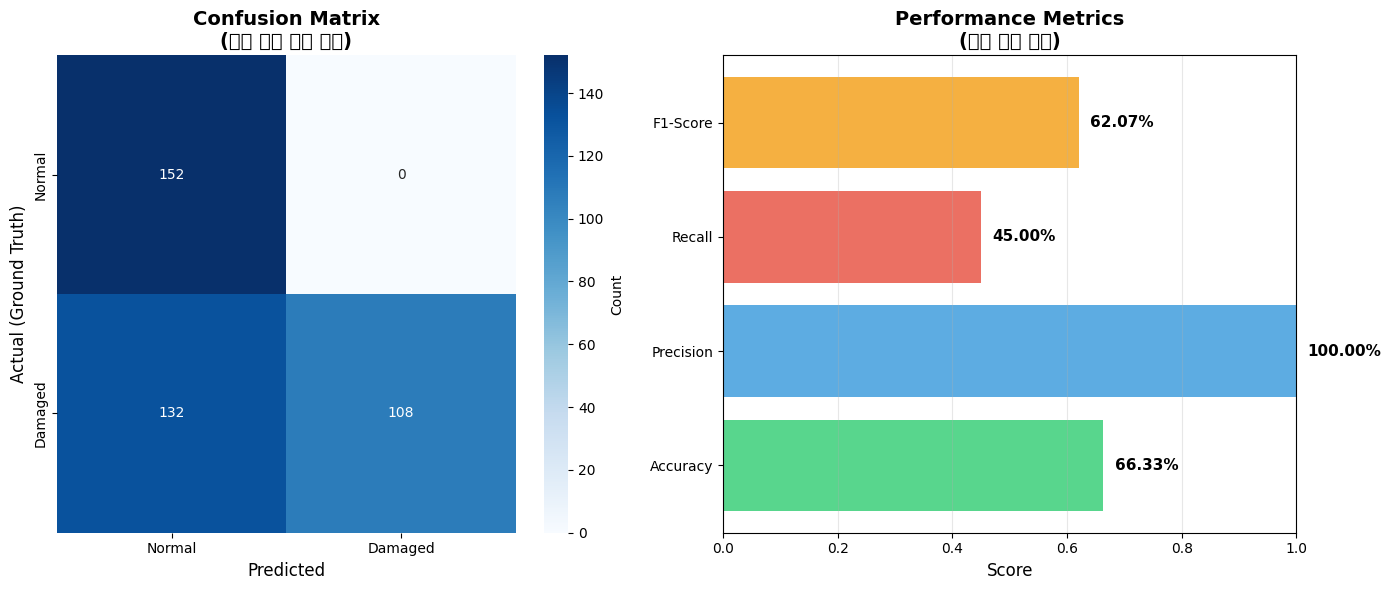


💾 그래프 저장: damage_only_evaluation.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔧 파손 검출 모델 로드...
✅ 로드 완료!


📂 데이터셋 평가 시작...
   이미지 폴더: yolo_dataset/images/val
   라벨 폴더: yolo_dataset/labels/val
   신뢰도 임계값: 0.5

총 392개 이미지 발견



평가 진행: 100%|██████████| 392/392 [00:08<00:00, 48.07it/s]
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-218574785.py:327: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}


✅ 평가 완료: 392개 이미지

📊 파손 검출 모델 성능 평가 결과

📋 Confusion Matrix:
┌─────────────┬──────────┬──────────┐
│             │ 예측:정상 │ 예측:파손 │
├─────────────┼──────────┼──────────┤
│ 실제:정상    │    152   │      0   │
│ 실제:파손    │    132   │    108   │
└─────────────┴──────────┴──────────┘

📈 성능 지표:
┌─────────────────────┬──────────┐
│ Accuracy (정확도)    │  66.33% │
├─────────────────────┼──────────┤
│ Precision (정밀도)   │ 100.00% │
├─────────────────────┼──────────┤
│ Recall (재현율)      │  45.00% │
├─────────────────────┼──────────┤
│ F1-Score            │  62.07% │
├─────────────────────┼──────────┤
│ Specificity (특이도) │ 100.00% │
└─────────────────────┴──────────┘

💡 상세 분석:
├── True Positive (TP): 108개
│   → 파손을 파손으로 정확히 검출
│
├── True Negative (TN): 152개
│   → 정상을 정상으로 정확히 판단
│
├── False Positive (FP): 0개 ⚠️  오탐
│   → 정상인데 파손으로 잘못 검출
│   → Precision이 낮아지는 원인
│
└── False Negative (FN): 132개 ⚠️  미탐
    → 파손인데 검출 못함
    → Recall이 낮아지는 원인

⭐ 종합 평가:
❌ 낮은 성능. 데이터 추가 또는 재학습 필요

💡 개선 제안:
   • 미탐(FN)이 많음: 13

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

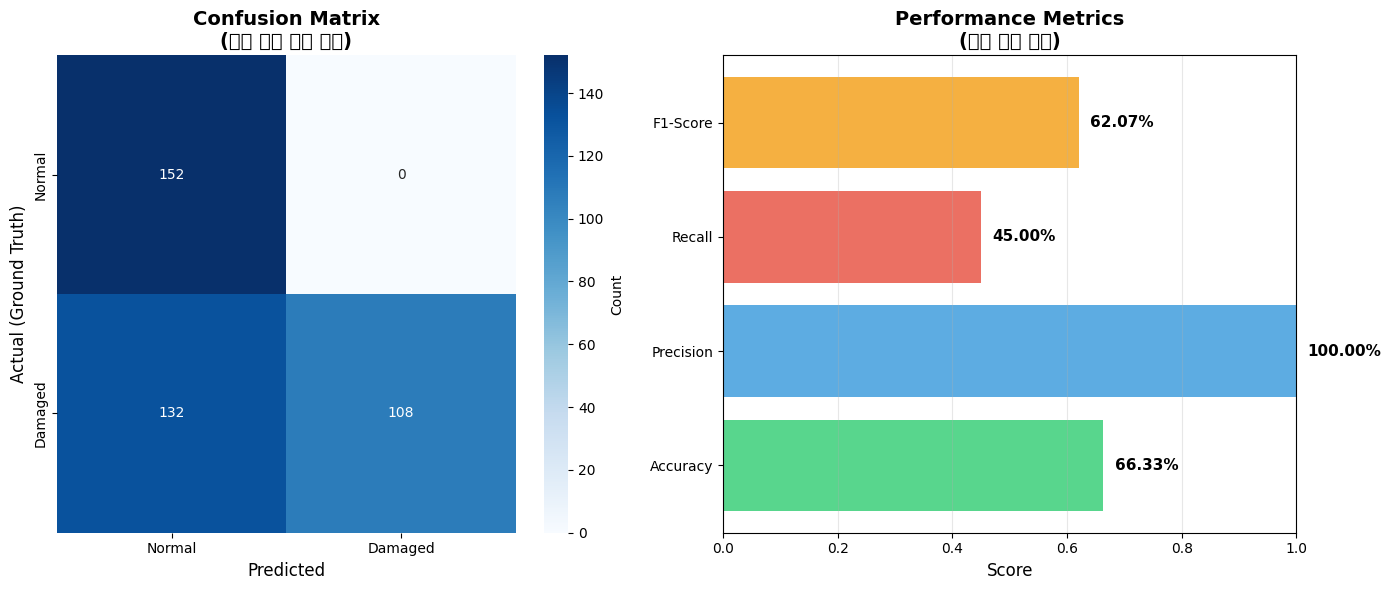


💾 그래프 저장: damage_only_evaluation.png


In [9]:
# ============================================================
# 🎯 파손 검출 모델 단독 평가
#    (자동차 인식 단계 제외)
# ============================================================


# ============================================================
# 💡 사용 방법
# ============================================================

# 초기화
evaluator = DamageOnlyEvaluator(
    damage_model_path='car_damage_model/train/weights/best.pt'
)

# Validation 데이터로 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 메트릭 계산
metrics = evaluator.calculate_metrics()

# CSV 저장
files = evaluator.save_to_csv(output_prefix='damage_only')

# 시각화
evaluator.visualize_results()

# 다운로드
from google.colab import files
files.download('damage_only_predictions.csv')
files.download('damage_only_metrics.csv')



# ============================================================
# 🚀 바로 실행 (아래 코드 복사하여 새 셀에서 실행)
# ============================================================

# 파손 검출 모델 단독 평가 시작
evaluator = DamageOnlyEvaluator()

# Validation 데이터 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 결과 분석
metrics = evaluator.calculate_metrics()

# CSV 저장
evaluator.save_to_csv()

# 시각화
evaluator.visualize_results()

In [10]:
# !mkdir /content/drive/MyDrive/result_251221

In [12]:
# !cp /content/*.csv /content/drive/MyDrive/result_251221/.

In [13]:
# !cp /content/*.xlsx /content/drive/MyDrive/result_251221/.

In [14]:
# !cp /content/*.png /content/drive/MyDrive/result_251221/.

In [15]:
# !cp /content/*.yaml /content/drive/MyDrive/result_251221/.